## Time series analysis using matrix profiles

A **matrix profile** is a vector that stores the z-normalized Euclidean distance between any subsequence within a time series and its nearest neighbor.  You can explore how matrix profiles are calculated in this great [tutorial](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html). 

Matrix profiles give us the ability to identify **motifs (patterns)** and **discords (anomalies)** in time series data.  Motifs are approximately repeated subsequences found within a longer time series that help us to identify approximate patterns.

Lots of papers have been published on the STOMP and corresponding algorithms and matrix profiling.  You can find a list [here](https://www.cs.ucr.edu/~eamonn/MatrixProfile.html).

Here I use the [`stumpy`](https://stumpy.readthedocs.io/en/latest/index.html) Python package to get the job done.  It highly optimized, well documented, and portable.  `stumpy` comes with a suite of informative [tutorials](https://stumpy.readthedocs.io/en/latest/tutorials.html) as well.


In [2]:
import os
import glob
import datetime as dt

import duckdb
import stumpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates

from matplotlib.patches import Rectangle


## Get a group of parquet files to work with

For this case, I'll grab three files that represent sample 1, realization 1, and demand rules 0-2.


In [3]:
# directory the data was downloaded to locally
data_dir = '/Users/d3y010/projects/antonia/data/xdd_parquet'

# target glob path
glob_path = os.path.join(data_dir, 'S1_1/S*_*_0.parquet')

# number of files in file query
n_files = len(glob.glob(glob_path))

# number of records in file query
n_records = n_files * 432180  # records per file

print("Exploring {:,} records over {} files.".format(n_records, n_files))


Exploring 432,180 records over 1 files.


## Setting up the data

#### Asking our question of the data

Since we will be working with time series data, we need to concatenate and cast our `year` and `month` fields into a datetime object.  We will name this new field `date_time` and produce it in the format `YYYY-MM`.  

For this exercise, I am only interested in one user, `structure_id = '5100848'` and one demand rule.  

I will ask for the data to be sorted in ascending order by our new `date_time` column.


In [7]:
%%time

# our target user
structure_id = '5100848'

sql = f"""
SELECT
    structure_id
    ,demand
    ,shortage
    ,strptime(
        CAST(year AS VARCHAR)
        || '-'
        || CASE month
            WHEN 'OCT' THEN '10'
            WHEN 'NOV' THEN '11'
            WHEN 'DEC' THEN '12'
            WHEN 'JAN' THEN '01'
            WHEN 'FEB' THEN '02'
            WHEN 'MAR' THEN '03'
            WHEN 'APR' THEN '04'
            WHEN 'MAY' THEN '05'
            WHEN 'JUN' THEN '06'
            WHEN 'JUL' THEN '07'
            WHEN 'AUG' THEN '08'
            WHEN 'SEP' THEN '09'
            END
        , '%Y-%m') AS date_time
FROM
    '{glob_path}' 
WHERE
    structure_id = '{structure_id}'
    AND "demand rule" = 0
ORDER BY
    date_time;
"""

# get query result as a data frame
df = duckdb.query(sql).df()


CPU times: user 27.7 ms, sys: 17.9 ms, total: 45.6 ms
Wall time: 44.6 ms


Oct 1908 - Sept 1909:  water year 1909

## Calculating our matrix profile

The `stump` workhorse function takes in a few arguments.  To see the full API view [here](https://stumpy.readthedocs.io/en/latest/api.html#stump).  We are going to set the required window size (`m`) to a years worth of our data.  Since our time step is monthly, we will set `m = 12`.

In [8]:
# window size
m = 12


Next, we will generate a matrix profile for our data field of interest.  The output of our profile, `mp`, is a NumPy array with four columns and the number of rows that corresponds to our input data time steps.  

The four columns of the matrix profile array output represent:  [0] the matrix profile, [1] the matrix profile indices, [2] the left matrix profile indices, and [4] the right matrix profile indices.


In [9]:
# data field to investigate
data_field = 'demand'

# cast to float; required by the stump algorithm
time_series = df[data_field].values.astype(np.float64)

# generate a matrix profile
mp = stumpy.stump(time_series, m)


## Identify our motif and its nearest neighbor

Let's calculate the index for the start of the motif and the index for the start of the motif's nearest neighbor.

In [10]:
# identify the index of the start of the motif
motif_idx = np.argsort(mp[:, 0])[0]

# identify the nearest neighbor start index to the motif
nearest_neighbor_idx = mp[motif_idx, 1]


## Exploring the motif

#### Plotting the data with its corresponding matrix profile and identified motif

This plot identifies the motif and its nearest neighbor within the time series.

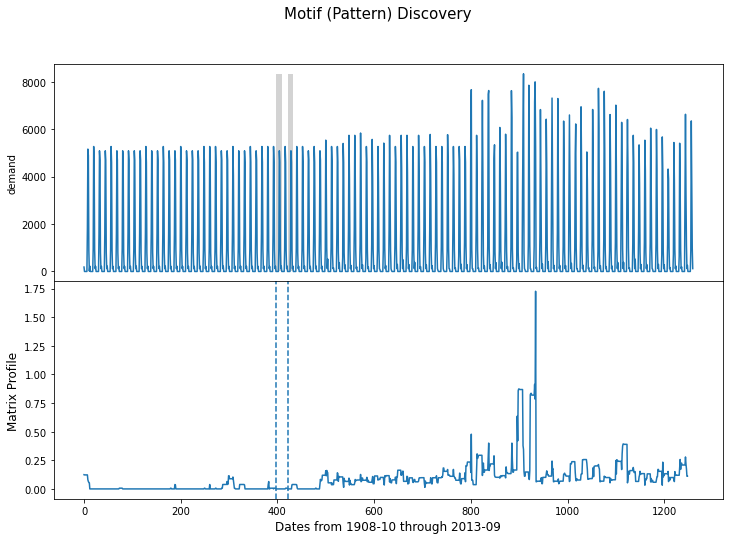

In [7]:
# set up the figure space
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(12, 8))

plt.suptitle('Motif (Pattern) Discovery', fontsize='15')

# add data field time series to plot
axs[0].plot(df[data_field].values)
axs[0].set_ylabel(data_field, fontsize='10')

# build shaded rectangle to identify the breadth of the motif
rect = Rectangle((motif_idx, 0), m, np.max(time_series), facecolor='lightgrey')
axs[0].add_patch(rect)

# build shaded rectangle to identify the breadth of the motif's nearest neighbor
rect = Rectangle((nearest_neighbor_idx, 0), m, np.max(time_series), facecolor='lightgrey')
axs[0].add_patch(rect)

# get the date bounds covered in the plot
min_yrmth = df['date_time'].min().strftime('%Y-%m')
max_yrmth = df['date_time'].max().strftime('%Y-%m')

axs[1].set_xlabel(f'Dates from {min_yrmth} through {max_yrmth}', fontsize ='12')
axs[1].set_ylabel('Matrix Profile', fontsize='12')

# add lines to identify the starting point of the motif and nearest neighbor
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")

# add motif profile plot
axs[1].plot(mp[:, 0])

plt.show()


### Zooming in on the subsequence

We can also explore the subsequence of the motif and nearest neighbor to see their actual similarity.

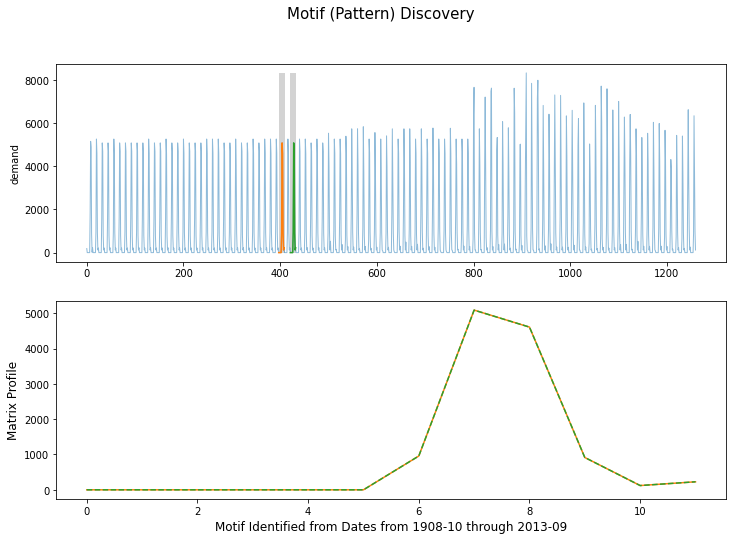

In [8]:
fig, axs = plt.subplots(2, figsize=(12, 8))

plt.suptitle('Motif (Pattern) Discovery', fontsize='15')

axs[0].set_ylabel(data_field, fontsize='10')

axs[0].plot(df[data_field], alpha=0.5, linewidth=1)
axs[0].plot(df[data_field].iloc[motif_idx:motif_idx+m])
axs[0].plot(df[data_field].iloc[nearest_neighbor_idx:nearest_neighbor_idx+m])

rect = Rectangle((motif_idx, 0), m, np.max(time_series), facecolor='lightgrey')
axs[0].add_patch(rect)

rect = Rectangle((nearest_neighbor_idx, 0), m, np.max(time_series), facecolor='lightgrey')
axs[0].add_patch(rect)

# get the date bounds covered in the plot
min_yrmth = df['date_time'].min().strftime('%Y-%m')
max_yrmth = df['date_time'].max().strftime('%Y-%m')

axs[1].set_xlabel(f'Motif Identified from Dates from {min_yrmth} through {max_yrmth}', fontsize ='12')
axs[1].set_ylabel('Matrix Profile', fontsize='12')

axs[1].plot(df[data_field].values[motif_idx:motif_idx+m], color='C1')
axs[1].plot(df[data_field].values[nearest_neighbor_idx:nearest_neighbor_idx+m], color='C2', linestyle="dashed")

plt.show()


## Exploring discordance (anomalies)

The index location within our matrix profile that has the largest value will correspond with the data that is the farthest distance from what we would expect to see, our an anomaly.


### Determine the index of the start position of the anomaly

In [9]:
discord_idx = np.argsort(mp[:, 0])[-1]


### Visualize the anomaly

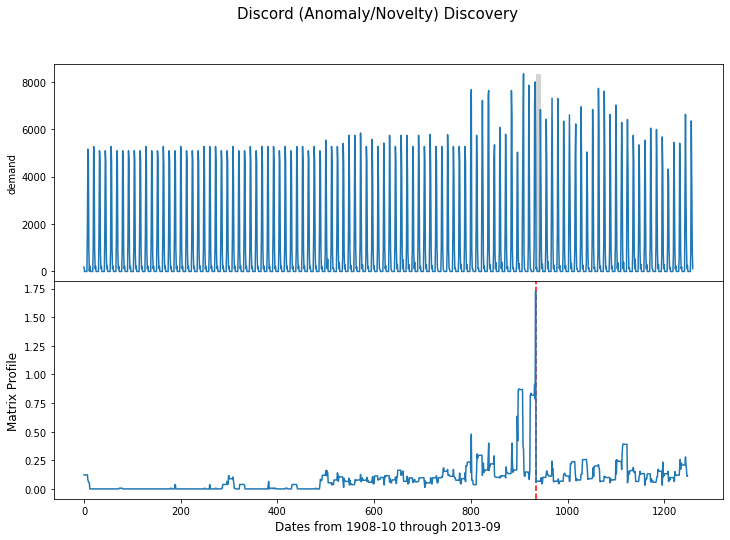

In [10]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(12, 8))

plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='15')

axs[0].plot(df[data_field].values)
axs[0].set_ylabel(data_field, fontsize='10')

rect = Rectangle((discord_idx, 0), m, np.max(time_series), facecolor='lightgrey')
axs[0].add_patch(rect)

# get the date bounds covered in the plot
min_yrmth = df['date_time'].min().strftime('%Y-%m')
max_yrmth = df['date_time'].max().strftime('%Y-%m')

axs[1].set_xlabel(f'Dates from {min_yrmth} through {max_yrmth}', fontsize ='12')
axs[1].set_ylabel('Matrix Profile', fontsize='12')

axs[1].axvline(x=discord_idx, linestyle="dashed", color='r')
axs[1].plot(mp[:, 0])

plt.show()


<br>

# Explore patterns in multiple demand rules for a user

## Setting up the data

#### Selecting our files

In this case, we will choose four different samples for realization 1 and demand rule 0.

In [19]:
#### Selecting our files
# directory the data was downloaded to locally
data_dir = '/Users/d3y010/projects/antonia/data/xdd_parquet'

# target glob path
glob_path = os.path.join(data_dir, 'S[1-4]_1/S*_*_0.parquet')

# number of files in file query
n_files = len(glob.glob(glob_path))

# number of records in file query
n_records = n_files * 432180  # records per file

print("Exploring {:,} records over {} files.".format(n_records, n_files))


Exploring 1,728,720 records over 4 files.


#### Asking our question of the data

For this exercise, I am going to create a new field named `sample_user` that is a concatenation of our `sample` and `structure_id`.  It will return values in this format:  `<sample>-<structure_id>`.

We are still only going to use a single user in this case. 

We will select all records starting in 2000 through year 2010.

I will ask for the data to be sorted in ascending order by our new `sample_user` column and then by our `date_time` column.


In [12]:
%%time

sql = f"""
SELECT
    sample || '-' || structure_id AS sample_user
    ,demand
    ,strptime(
        CAST(year AS VARCHAR)
        || '-'
        || CASE month
            WHEN 'OCT' THEN '10'
            WHEN 'NOV' THEN '11'
            WHEN 'DEC' THEN '12'
            WHEN 'JAN' THEN '01'
            WHEN 'FEB' THEN '02'
            WHEN 'MAR' THEN '03'
            WHEN 'APR' THEN '04'
            WHEN 'MAY' THEN '05'
            WHEN 'JUN' THEN '06'
            WHEN 'JUL' THEN '07'
            WHEN 'AUG' THEN '08'
            WHEN 'SEP' THEN '09'
            END
        , '%Y-%m') AS date_time
FROM
    '{glob_path}' 
WHERE
    structure_id ='5100848'
    AND year BETWEEN 2000 AND 2010
ORDER BY
    sample_user
    ,date_time;
"""

# get query result as a data frame
df = duckdb.query(sql).df()


CPU times: user 69.3 ms, sys: 121 ms, total: 190 ms
Wall time: 427 ms


#### Reformatting the data for our visualizations

Our data comes out in this form:

In [13]:
df.head(2)


,sample_user,demand,date_time
0,1-5100848,0,2000-01-01
1,1-5100848,0,2000-02-01


We need to reformat our data so that we may call each column individually.  So let's pivot:


In [14]:
dfp = df.pivot(index='date_time', columns='sample_user', values='demand').astype(np.float64)

dfp.head(2)


sample_user,1-5100848,2-5100848,3-5100848,4-5100848
date_time,,,,
2000-01-01,0.0,0.0,0.0,0.0
2000-02-01,0.0,0.0,0.0,0.0


### Calculating our multidimensional matrix profile

It is important to note that multidimensional matrix profiles are NOT 1-dimensional profiles stacked on top of one another.  You can do more reading on these types of profiles [here](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html#Multi-dimensional-Matrix-Profiles).

We now use the `mstump` function to calculate the multidimensional matrix profile.  You can explore the full breadth of this function in the [API docs](https://stumpy.readthedocs.io/en/latest/api.html#stumpy.mstump).


In [15]:
# our windown size
m = 12

# calculate our matrix profile and indices
mps, indices = stumpy.mstump(dfp, m)


Identify the motif index value by locating the two lowest values in the matrix profile.


In [16]:
motifs_idx = np.argsort(mps, axis=1)[:, :2]


## Exploring the motifs

Let's examine the motifs as they fit each sample.

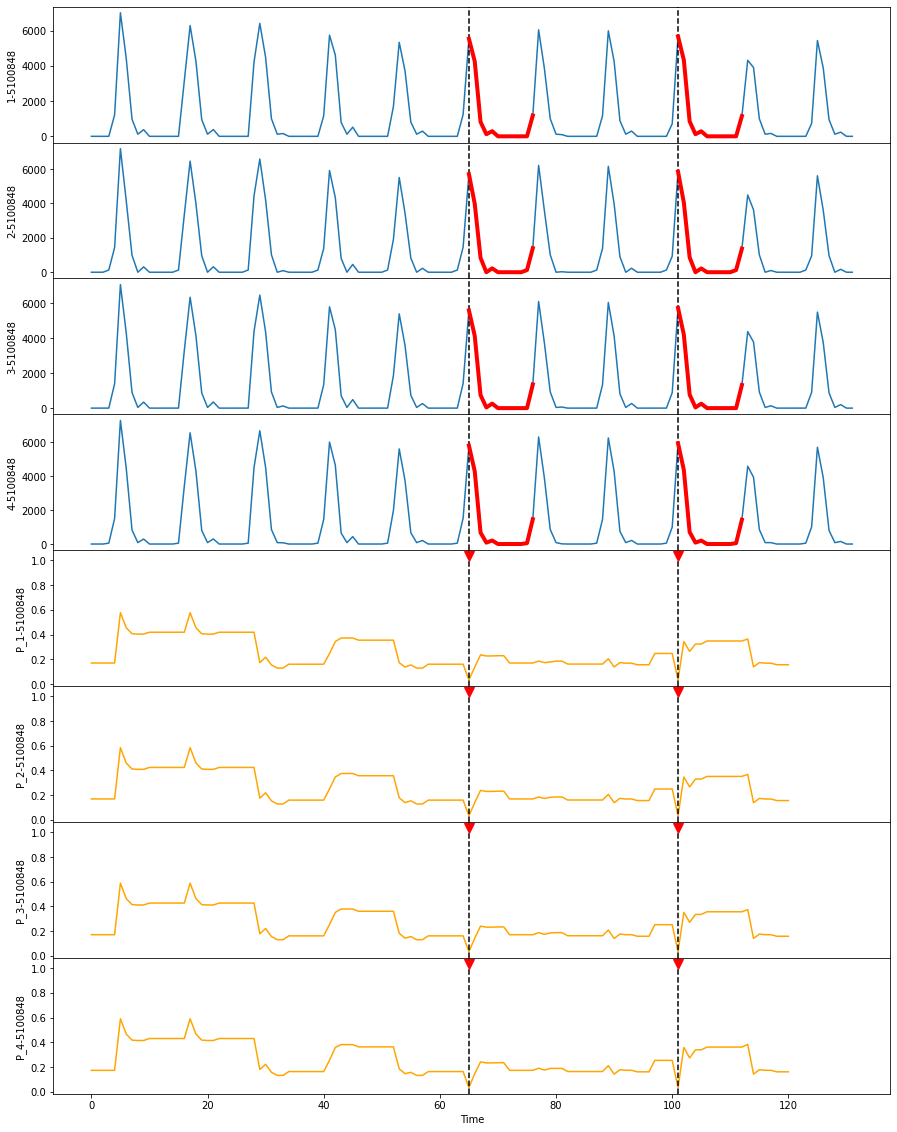

In [17]:
fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(15, 20))

# process each user
for k, dim_name in enumerate(dfp.columns):
    
    # generate a name for the corresponding matrix profile plot
    profile_name = f"P_{dim_name}"    
    
    # plot time series of data field for the target user
    axs[k].set_ylabel(dim_name, fontsize='10', rotation=90)
    axs[k].plot(dfp[dim_name].values)
    axs[k].set_xlabel('Time', fontsize ='10')

    # plot the corresponding matrix profile
    axs[k + mps.shape[0]].set_ylabel(profile_name, fontsize='10', rotation=90)
    axs[k + mps.shape[0]].plot(mps[k], c='orange')
    axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='10')

    # add in lines for motif identification in the data plot
    axs[k].axvline(x=motifs_idx[1, 0], linestyle="dashed", c='black')
    axs[k].axvline(x=motifs_idx[1, 1], linestyle="dashed", c='black')
    
    # add in lines for motif identification in the matrix profile
    axs[k + mps.shape[0]].axvline(x=motifs_idx[1, 0], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=motifs_idx[1, 1], linestyle="dashed", c='black')

    # highlight each motif and neighbor in the data in red
    axs[k].plot(range(motifs_idx[k, 0], motifs_idx[k, 0] + m), dfp[dim_name].iloc[motifs_idx[k, 0] : motifs_idx[k, 0] + m], c='red', linewidth=4)
    axs[k].plot(range(motifs_idx[k, 1], motifs_idx[k, 1] + m), dfp[dim_name].iloc[motifs_idx[k, 1] : motifs_idx[k, 1] + m], c='red', linewidth=4)
    
    # add pointer to each motif and neighbor in the matrix profile
    axs[k + mps.shape[0]].plot(motifs_idx[k, 0], mps[k, motifs_idx[k, 0]] + 1, marker="v", markersize=10, color='red')
    axs[k + mps.shape[0]].plot(motifs_idx[k, 1], mps[k, motifs_idx[k, 1]] + 1, marker="v", markersize=10, color='red')
    
plt.show()



We can see in this case that the patterns are similar but we can still identify the "right" motif by generating a simple elbow/knee plot to identify the maximium point of curvature for our profiles.

Sample 2 (shown as k(zero-based) 1) contains the most appropriate motif.


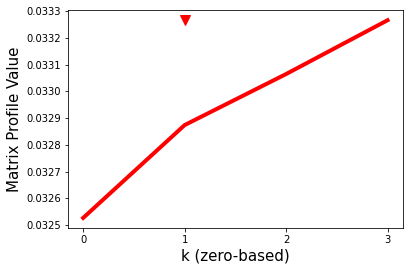

In [18]:
# generate an array of low point profile values
k_values = mps[range(mps.shape[0]), motifs_idx[:, 0]]

plt.plot(k_values, c='red', linewidth='4')
plt.xlabel('k (zero-based)', fontsize='15')
plt.ylabel('Matrix Profile Value', fontsize='15')
plt.xticks(range(mps.shape[0]))

# point at the elbow
plt.plot(1, np.max(k_values), marker="v", markersize=10, color='red')

plt.show()
